In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
import math
from PIL import Image
from scipy import ndimage



### Step 1. 스티커 구하기 or 만들기

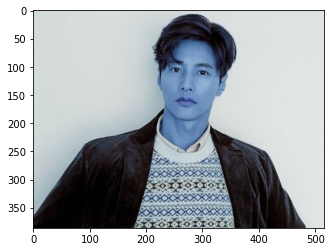

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/원빈.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

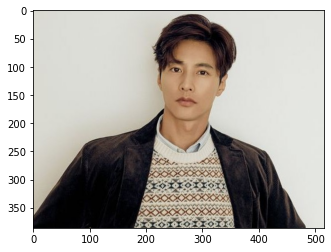

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [4]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()
print("🌫🛸")

🌫🛸


In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("🌫🛸")

🌫🛸


rectangles[[(223, 80) (330, 187)]]


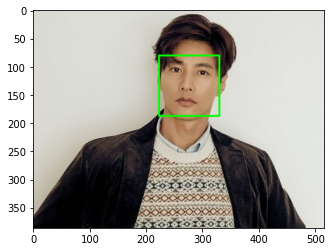

In [6]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [7]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [8]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


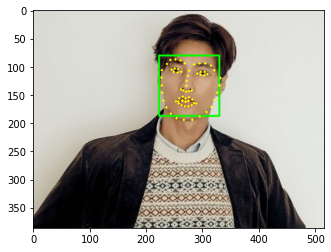

In [9]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### Step 3. 스티커 적용 위치 확인하기

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # 코밑의 index는 33 입니다
    x = landmark[33][0]
    y = landmark[33][1] 
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(271, 144)
(x,y) : (271,144)
(w,h) : (108,108)


이미지에서는 코의 중심에서 밑에 점이 (271, 134) 로 나오네요.우 x, y 는 x좌표는 그대로 두고 y 좌표는 4 정도 내려주었다.

In [11]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (50,50))
print (img_sticker.shape)

(50, 50, 3)


수염의 크기는 (50,50) 정도가 적당해 보인다. 

수염 이미지를 읽고 윗 단계에서 계산한 크기로 resize 합니다.

원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 콧수염 좌표는 조금씩 이동시켜서 맞춰준다.

In [12]:
refined_x = x - w // 5
refined_y = y -15
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (250,129)


In [13]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
print("슝~")

슝~


In [14]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (250,129)


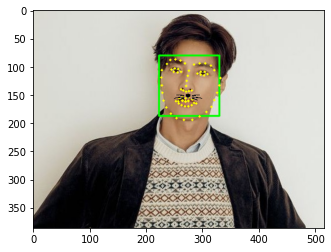

In [15]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

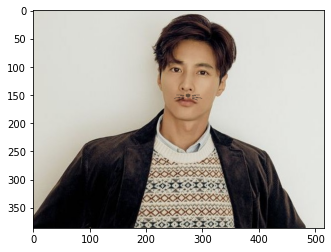

(None, 0)

In [16]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)# 불투명도 조정
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show(),0

cv2.addWeighted를 사용해 수염을 반투명하게 해주었다. 

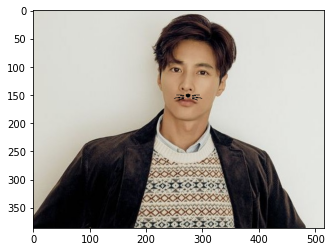

In [17]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

그래도 까만수염이 좋은것 같다. <br> 원빈에게 이쁜 수염이 생겼다. 

### Step 5. 문제점 찾아보기

또 다른 문제점을 찾기 위해 다른 각도의 원빈 사진을 준비해서 진행하겠다. 

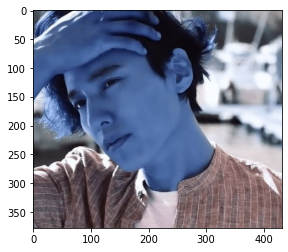

In [18]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/원빈2.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

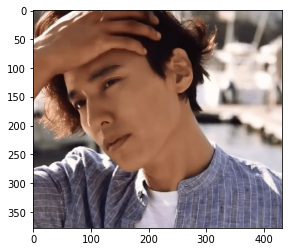

In [19]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [20]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()
print("🌫🛸")

🌫🛸


In [21]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("🌫🛸")

🌫🛸


rectangles[]


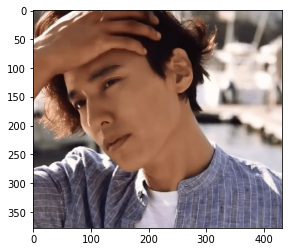

In [22]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

여기 원빈은 얼굴각도가 옆으로 되어 있어서 그런지 얼굴을 인식을 못한다.

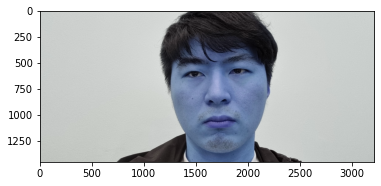

In [23]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image5.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

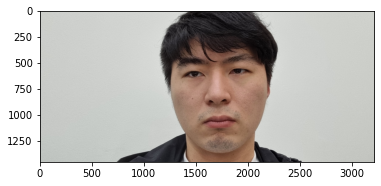

In [24]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [25]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()
print("🌫🛸")

🌫🛸


In [26]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("🌫🛸")

🌫🛸


rectangles[[(1256, 298) (2214, 1256)]]


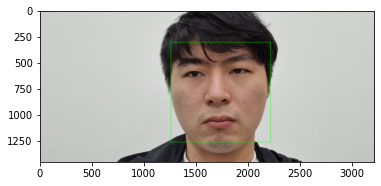

In [27]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

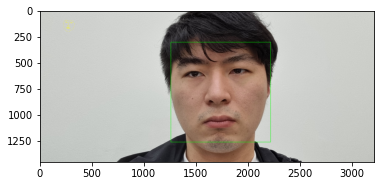

In [28]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

하지만 랜드마크를 찾지 못하는 모습을 보여준다. 

내 얼굴에서 랜드마크를 찾지 못하는 이유는 두가지로 추측해볼 수 있는데 너무 가까이 찍어서 얼굴 사이즈가 커서 랜드마크를 못찾는 것과 앞머리가 눈썹하고 구분이 잘 안가서 얼굴형을 잘 인식하지 못하는거 같은데 조금더 신뢰가 가는 쪽은 전자인 것 같다. 



또다른 문제점은 어두운 곳에서는 인식이 또 되지 않아 적당한 밝기가 있어야 하고, 옆을 쳐다보고 있으면 눈 코 입 을 모두 인식해야 하는데 인식을 못할 확률이 높다. 각도가 틀리면 이미지를 합성해도 뭔가 어색해지는 문제점이 생길 것 같다. 

만일 각도가 문제라면 그래도 수염 이미지를 회전 시켜서 적용해주면 어느정도 어색함은 해결될 것이다. 

(50, 50, 3)


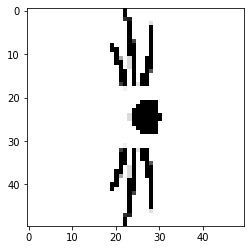

In [36]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker_rotate = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker_rotate = cv2.resize(img_sticker_rotate, (50,50))
print (img_sticker_rotate.shape)
img_sticker_rotate_clockwise = cv2.rotate(img_sticker_rotate, cv2.ROTATE_90_CLOCKWISE)
plt.imshow(img_sticker_rotate_clockwise)
plt.show()

물론 이렇게 90도 짜리 수염을 넣기 위해서는 옆으로 누운 사진이거나 그래야 가능 할 것이다. 

최대한 비슷하게 사진에 적용하기 위해서는 사진 각도만큼 따라가야한다.  현재 우리는 index 33을 기준으로 잡았는데 index 33 위치가 27 위치로 바뀌었으면 수염도 그만큼 따라가 주면 된다.

In [34]:
# vector 계산
landmark = list_landmarks[0]
v1 = np.array([0, -1])
v2 = np.array([abs(landmark[33][0] - landmark[27][0]), abs(landmark[33][1] - landmark[27][1])])
unit_vector_1 = v1 / np.linalg.norm(v1)
unit_vector_2 = v2 / np.linalg.norm(v2)
dot_product = np.dot(unit_vector_1, unit_vector_2)
angle = np.arccos(dot_product)

<function matplotlib.pyplot.show(close=None, block=None)>

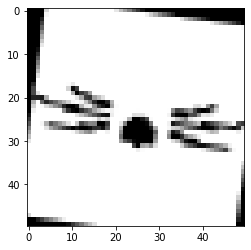

In [35]:
# 회전 변환
rows, cols = img_sticker.shape[:2]
img_sticker_rot = cv2.warpAffine(img_sticker, cv2.getRotationMatrix2D((cols/2, rows/2), math.degrees(angle), 1), (cols, rows))
plt.imshow(img_sticker_rot)
plt.show

### 회고
아직 모델이 완벽하지 못해서 조건이 거의 완벽한 사진이 아니면 인식을 못해 아쉽지만 회전 문제를 해결할 수 있는 것처럼 명암 같은것도 필터가 발달해서 더 잘 구분할 수 있게 되면 성능을 더 끌어올릴 수 있을 것 같다. 실행속도나 정확도는 어느정도 기준을 벗어나지 않는다면 웃으면서 넘어갈 수 있을 것 같다. 